In [14]:
import sys
import numpy
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
from scipy.ndimage import label


def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None;
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [15]:
import os
import glob
import re
import pandas as pd
from tqdm import tqdm

def to_df(mmms_folder_name, pop_parameter, verbose = False):
    # Define pattern to match values from lines
    prob_pattern_pop = r"Probability: P\(mass <= max_mass\(spin, eos\)\) = ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"
    odds_pattern_pop = r"Odds Ratio\s*:.*= ([\d\.eE+-]+) \+/- ([\d\.eE+-]+)"

    prob_pattern_np = prob_pattern_pop
    odds_pattern_np = odds_pattern_pop

    prob_pattern_eos = r"Probability: P\(.*?\) = ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"
    odds_pattern_eos = r"Odds Ratio\s*:.*?= ([0-9.eE+-]+) \+/- ([0-9.eE+-]+)"


    # Create list to hold parsed data
    data = []

    # Loop through all .out files
    glob_path = f"../{mmms_folder_name}/*.out"
    for filepath in glob.glob(glob_path):

        if re.search(r"EOS", filepath):
            prob_pattern = prob_pattern_eos
            odds_pattern = odds_pattern_eos 
        elif re.search(r"non-parametric", filepath):
            prob_pattern = prob_pattern_np
            odds_pattern = odds_pattern_np 
        else:
            prob_pattern = prob_pattern_pop
            odds_pattern = odds_pattern_pop 


        with open(filepath, "r") as f:
            content = f.read()
            prob_match = re.search(prob_pattern, content)
            odds_match = re.search(odds_pattern, content)

            if prob_match and odds_match:
                prob, prob_err = map(float, prob_match.groups())
                odds, odds_err = map(float, odds_match.groups())
                data.append({
                    "filename": filepath,
                    "probability": prob,
                    "prob_error": prob_err,
                    "odds_ratio": odds,
                    "odds_error": odds_err
                })
            else:
                if verbose:
                    print(f"Warning: Could not parse values from {filepath}")

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)
    
    # Wrangle more
    df[pop_parameter] = df["filename"].str.extract(fr"{pop_parameter}\+(-?[\d.]+)").astype(float)
    df["event"] = df["filename"].str.extract(r"(GW\d+)")
    df["component"] = df["filename"].str.extract(r"component(\d+)").astype(int)
    return df

def simple_grid_plot(df, pop_parameter):
    GW190917_m1 = df[(df['event'] == "GW190917") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190917_m2 = df[(df['event'] == "GW190917") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW230529_m1 = df[(df['event'] == "GW230529") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190814_m2 = df[(df['event'] == "GW190814") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m1 = df[(df['event'] == "GW190425") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW190425_m2 = df[(df['event'] == "GW190425") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m1 = df[(df['event'] == "GW200105") & (df['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200105_m2 = df[(df['event'] == "GW200105") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    GW200115_m2 = df[(df['event'] == "GW200115") & (df['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    plt.figure()
    objects_lst = [GW230529_m1, GW190814_m2, GW190917_m2, GW190917_m1, GW190425_m2, GW190425_m1, GW200105_m2, GW200105_m1, GW200115_m2]
    objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    objects_colors = [ plt.get_cmap("nipy_spectral")(i / (len(objects_lst) - 1)) for i in range(len(objects_lst))]

    for i in range(len(objects_lst)):
        curr = objects_lst[i]
        curr_name = objects_names[i]
        p05 = curr["probability"] - curr["prob_error"] * 2
        p95 = curr["probability"] + curr["prob_error"] * 2
        if i == len(objects_lst) - 1:
            lab = "95\% CI"
        else:
            lab = None
        plt.plot(curr[pop_parameter], curr["probability"], label=curr_name, color = objects_colors[i])
        plt.fill_between(curr[pop_parameter], p05, p95, color="grey", alpha=0.2, label=lab)

    plt.ylabel("P(NS)")
    plt.xlabel(f"{pop_parameter}")
    plt.utkarshWrapper()
    plt.show()

In [16]:
import json

with open("folder2pop_parameter.json", "r") as f:
    folder2pop_parameter = json.load(f)

In [17]:
folders = [f for f in os.listdir("../") if os.path.isdir(os.path.join("../", f)) and f.startswith("grid")]
label_lst = [f[len("grid")+1:] for f in folders]
exclude_lst = ["gamma_low_debug", "plots", "mmms_plot_gamma_low", "mu_cos_tilt_debug", "mmms_plot_beta_low"]

# exclude_lst.append("mu_chi1_EOS") # Run in progress
# exclude_lst.append("sigma_chi_EOS") # Run in progress

df_lst = []

for label in tqdm(label_lst):
    if label in exclude_lst:
        df = pd.DataFrame()
        df_lst.append(df)
        continue

    pop_parameter = folder2pop_parameter[label]

    df = to_df(f"grid_{label}", pop_parameter)

    # Check if pop_parameter column exists
    if pop_parameter not in df.columns:
        print(f"[ERROR] Dataframe with {label} is missing the column '{pop_parameter}'")
        display(df)
        break

    # Ensure dataframe does not have None's in them
    # Check if any item in the DataFrame is None
    has_none = (df.isnull().values.any() or (df == None).values.any())
    if has_none:
        print(f"[ERROR] Dataframe with {label} has None values in it")
        display(df)
        break

    df_lst.append(df)
    pop_parameter = None

results = dict(zip(label_lst, df_lst))

results_serializable = {k: v.to_dict(orient="list") for k, v in results.items()}
with open("results.json", "w") as f:
    json.dump(results_serializable, f, indent=2)

100%|██████████| 43/43 [04:12<00:00,  5.87s/it]


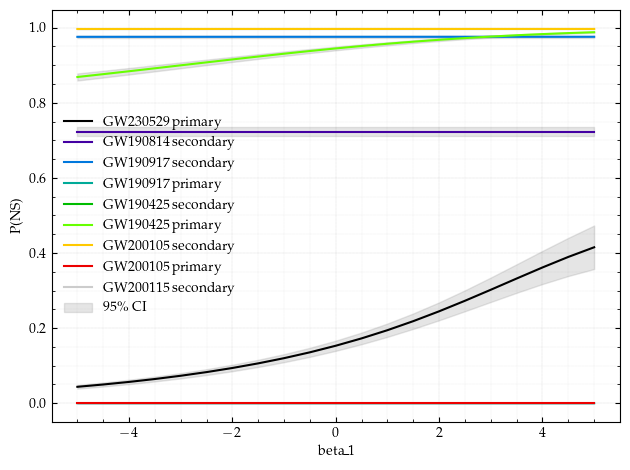

In [24]:
item = "beta_low_NS"
simple_grid_plot(results[item], folder2pop_parameter[item])

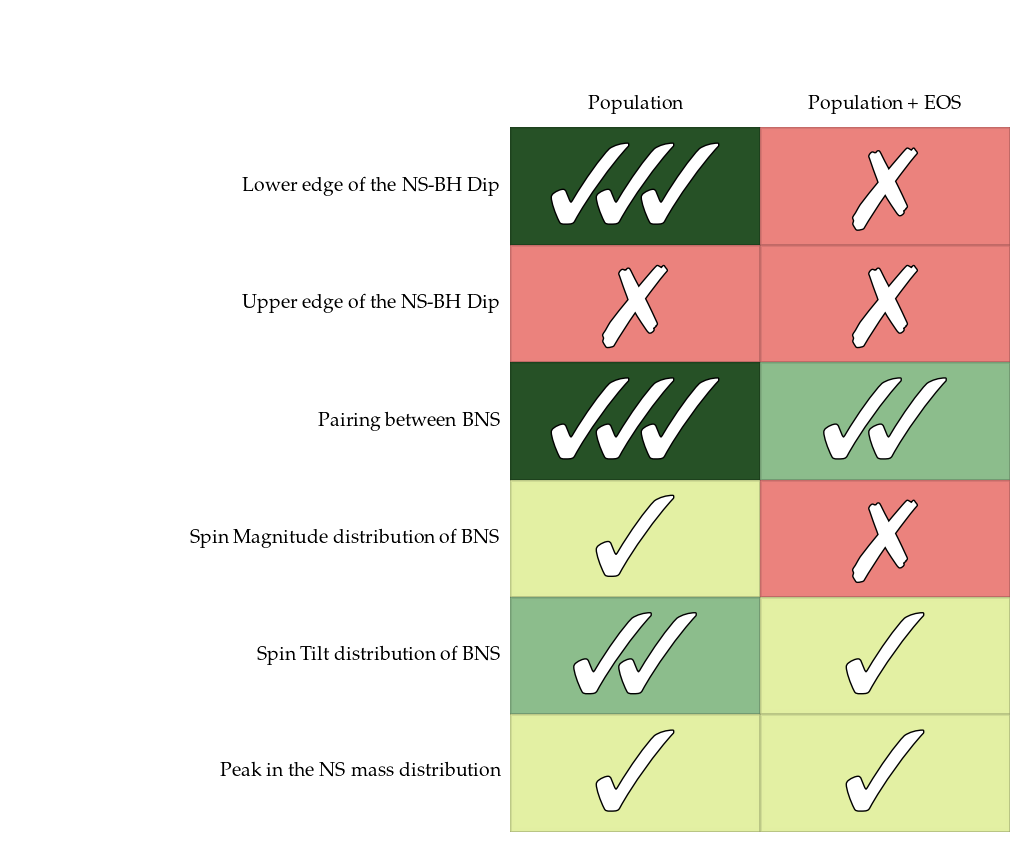

In [47]:
# Matrix grid: text + color box with tick/crosses, with title row and LaTeX/Unicode support
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as patheffects
from matplotlib.ticker import MaxNLocator

plt.rcParams['text.latex.preamble'] = r"\usepackage{amssymb, pifont, wasysym, xcolor}"


tick = r'\ding{51}'
cross = r'\ding{55}'

_gamma_low = "Lower edge of the NS-BH Dip"
_gamma_high = "Upper edge of the NS-BH Dip" 
# _beta_low =  
_beta_low_NS = "Pairing between BNS" 
_mu_sigma = "Spin Magnitude distribution of BNS"
_mu_costilt =  "Spin Tilt distribution of BNS"
# _sig_costilt =  
_mu_peak_NS = "Peak in the NS mass distribution"
# _sig_peak_NS = 
_amax = "Maximum value of NS Spin"

row_labels = [_gamma_low, _gamma_high, _beta_low_NS,_mu_sigma, _mu_costilt, _mu_peak_NS]

# 0: cross, 1: one tick, 2: two ticks, 3: three ticks
col_pop = [3, 0, 3, 1, 2, 1]
col_eos = [0, 0, 2, 0, 1, 1]

# Color and symbol logic
# 0: cross, red; 1: one tick, yellow; 2: two ticks, green; 3: three ticks, very dark green
color_map = {
    0: ("#EB827D", cross),           # red
    1: ("#E3F0A3", tick),           # yellow
    2: ("#8CBD8C", tick),           # green
    3: ("#265126", tick)            # very dark green
}

nrows = len(row_labels)
fig = plt.figure(figsize=(10, 1.2 * (nrows + 1)))
gs = gridspec.GridSpec(nrows + 1, 3, width_ratios=[2, 1, 1], wspace=0.0, hspace=0.0)  # wspace=0.0, hspace=0.0 for touching

TEXT_SIZE = 14
SIZE = 80
Y = 0.4
SPACING = 0.18
FONT = "Arial"

# Title row 
ax_title0 = fig.add_subplot(gs[0, 0])
# ax_title0.text(0.5, 0.5, "Feature", ha='center', va='center', fontsize=10, fontweight='bold')
ax_title0.axis('off')
ax_title1 = fig.add_subplot(gs[0, 1])
ax_title1.text(0.5, 0.2, "Population", ha='center', va='center', fontsize=TEXT_SIZE, fontweight='bold')
ax_title1.axis('off')
ax_title2 = fig.add_subplot(gs[0, 2])
ax_title2.text(0.5, 0.2, "Population + EOS", ha='center', va='center', fontsize=TEXT_SIZE, fontweight='bold')
ax_title2.axis('off')

# Data rows
for i, label in enumerate(row_labels):
    # First column: text 
    ax0 = fig.add_subplot(gs[i + 1, 0])
    ax0.text(0.98, 0.5, label, ha='right', va='center', fontsize=TEXT_SIZE)
    ax0.axis('off')
    # Second column: color box with ticks/cross 
    ax1 = fig.add_subplot(gs[i + 1, 1])
    color, symbol = color_map[col_pop[i]]
    rect1 = Rectangle((0, 0), 1, 1, color=color, alpha=0.85,
                      path_effects=[patheffects.withStroke(linewidth=6, foreground='black', alpha=0.3),
                                    patheffects.withStroke(linewidth=2, foreground='black', alpha=0.7)])
    ax1.add_patch(rect1)
    # Fuzzy black outline
    rect1_outline = Rectangle((0, 0), 1, 1, fill=False, linewidth=0.1, edgecolor='black',
                              path_effects=[patheffects.withStroke(linewidth=0.1, foreground='black', alpha=0.5)])
    ax1.add_patch(rect1_outline)
    if col_pop[i] == 0:
        ax1.text(0.5, Y, cross, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    else:
        for t in range(col_pop[i]):
            ax1.text(0.5 + (t-((col_pop[i]-1)/2))*SPACING, Y, tick, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    # Third column: color box with ticks/cross 
    ax2 = fig.add_subplot(gs[i + 1, 2])
    color, symbol = color_map[col_eos[i]]
    rect2 = Rectangle((0, 0), 1, 1, color=color, alpha=0.85,
                      path_effects=[patheffects.withStroke(linewidth=6, foreground='black', alpha=0.3),
                                    patheffects.withStroke(linewidth=2, foreground='black', alpha=0.7)])
    ax2.add_patch(rect2)
    # Fuzzy black outline
    rect2_outline = Rectangle((0, 0), 1, 1, fill=False, linewidth=0.1, edgecolor='black',
                              path_effects=[patheffects.withStroke(linewidth=0.1, foreground='black', alpha=0.5)])
    ax2.add_patch(rect2_outline)
    if col_eos[i] == 0:
        ax2.text(0.5, Y, cross, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    else:
        for t in range(col_eos[i]):
            ax2.text(0.5+ (t-((col_eos[i]-1)/2))*SPACING, Y, tick, ha='center', va='center', fontsize=SIZE, color='white', fontweight='bold', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'),patheffects.Normal()])
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')

# Restore original 
plt.tight_layout(pad=0)
plt.savefig("plots/results_matrix.png")
plt.show()

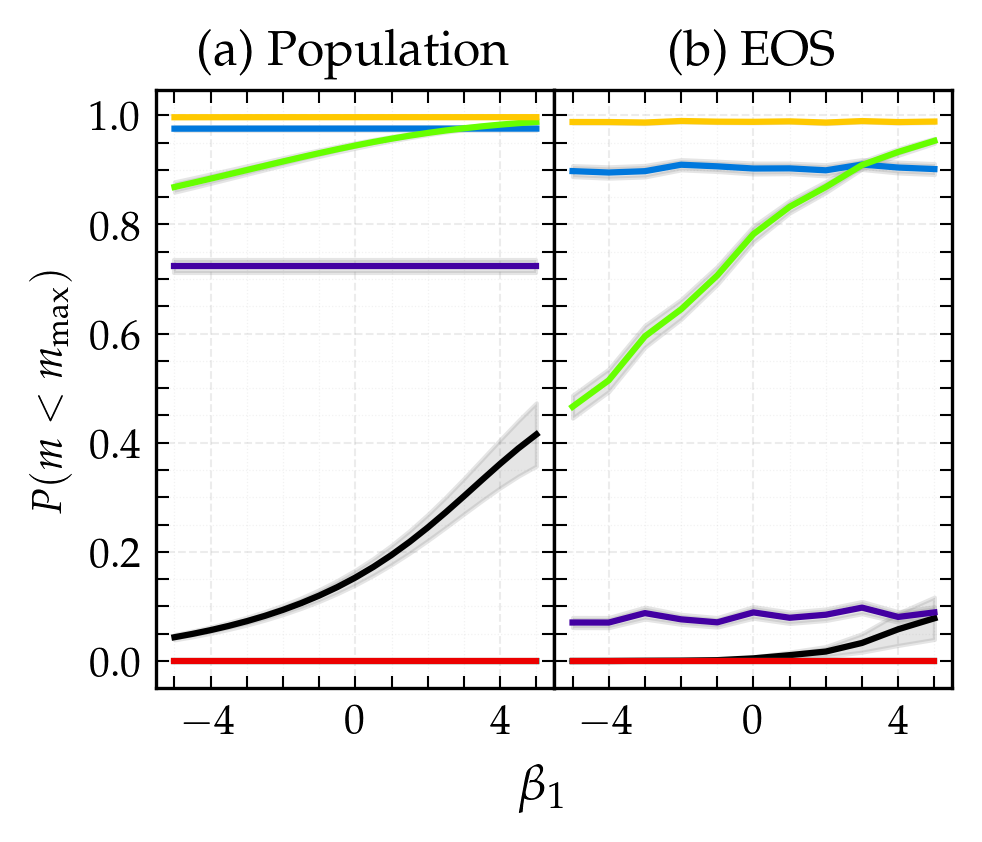

In [77]:
def eos_pop_grid(df_pop, df_eos, pop_parameter):
    pop_GW190917_m1 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190917_m2 = df_pop[(df_pop['event'] == "GW190917") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW230529_m1 = df_pop[(df_pop['event'] == "GW230529") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190814_m2 = df_pop[(df_pop['event'] == "GW190814") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m1 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW190425_m2 = df_pop[(df_pop['event'] == "GW190425") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m1 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200105_m2 = df_pop[(df_pop['event'] == "GW200105") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_GW200115_m2 = df_pop[(df_pop['event'] == "GW200115") & (df_pop['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    pop_objects_lst = [pop_GW230529_m1, pop_GW190814_m2, pop_GW190917_m2, pop_GW190917_m1, pop_GW190425_m2, pop_GW190425_m1, pop_GW200105_m2, pop_GW200105_m1, pop_GW200115_m2]
    pop_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    pop_objects_colors = [ plt.get_cmap("nipy_spectral")(i / (len(pop_objects_lst) - 1)) for i in range(len(pop_objects_lst))]

    eos_GW190917_m1 = df_eos[(df_eos['event'] == "GW190917") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190917_m2 = df_eos[(df_eos['event'] == "GW190917") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW230529_m1 = df_eos[(df_eos['event'] == "GW230529") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190814_m2 = df_eos[(df_eos['event'] == "GW190814") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190425_m1 = df_eos[(df_eos['event'] == "GW190425") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW190425_m2 = df_eos[(df_eos['event'] == "GW190425") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200105_m1 = df_eos[(df_eos['event'] == "GW200105") & (df_eos['component'] == 1)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200105_m2 = df_eos[(df_eos['event'] == "GW200105") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_GW200115_m2 = df_eos[(df_eos['event'] == "GW200115") & (df_eos['component'] == 2)].sort_values(by=pop_parameter).reset_index(drop=True)
    eos_objects_lst = [eos_GW230529_m1, eos_GW190814_m2, eos_GW190917_m2, eos_GW190917_m1, eos_GW190425_m2, eos_GW190425_m1, eos_GW200105_m2, eos_GW200105_m1, eos_GW200115_m2]
    eos_objects_names = ["GW230529 primary", "GW190814 secondary", "GW190917 secondary", "GW190917 primary", "GW190425 secondary", "GW190425 primary", "GW200105 secondary", "GW200105 primary", "GW200115 secondary"]
    eos_objects_colors = [ plt.get_cmap("nipy_spectral")(i / (len(eos_objects_lst) - 1)) for i in range(len(eos_objects_lst))]

    event_exclusion_lst = []

    width = 3.375  # inches
    height = 3.0  
    fig = plt.figure(figsize=(width, height), dpi=300)
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0)

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    # === Plot population objects ===
    for i, curr in enumerate(pop_objects_lst):
        curr_name = pop_objects_names[i]
        p05 = curr["probability"] - 2 * curr["prob_error"]
        p95 = curr["probability"] + 2 * curr["prob_error"]
        lab = "95\% CI" if i == len(pop_objects_lst) - 1 else None
        ax0.plot(curr[pop_parameter], curr["probability"], label=curr_name, color=pop_objects_colors[i])
        ax0.fill_between(curr[pop_parameter], p05, p95, color="grey", alpha=0.2, label=lab)

    # === Plot EOS objects ===
    for i, curr in enumerate(eos_objects_lst):
        curr_name = eos_objects_names[i]
        p05 = curr["probability"] - 2 * curr["prob_error"]
        p95 = curr["probability"] + 2 * curr["prob_error"]
        lab = "95\% CI" if i == len(eos_objects_lst) - 1 else None
        ax1.plot(curr[pop_parameter], curr["probability"], label=curr_name, color=eos_objects_colors[i])
        ax1.fill_between(curr[pop_parameter], p05, p95, color="grey", alpha=0.2, label=lab)

    # === Share y-axis ===
    ax1.sharey(ax0)

    # === Format axes ===
    for ax in [ax0, ax1]:
        ax.tick_params(
            direction='in',       # Ticks inward
            top=True,             # Show top ticks
            right=True,           # Show right ticks
            which='both',         # Major and minor ticks
            length=3, width=0.5
        )

    for ax in [ax0, ax1]:
        ax.minorticks_on()
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5, alpha=0.15)
        ax.grid(which='minor', axis='both', color='gray', linestyle=':', linewidth=0.3, alpha=0.1)

    # Remove y-axis labels and ticks on right plot
    ax1.tick_params(labelleft=False)
    ax1.set_ylabel("")
    
    # Titles
    ax0.set_title(r'(a) Population')
    ax1.set_title(r'(b) EOS')

    # Shared x and y labels
    fig.supxlabel(rf'$\{pop_parameter}$', y=0.08, x = 0.55)
    ax0.set_ylabel(r'$P(m < m_{\mathrm{max}})$')

    # Adjust layout to accommodate supxlabel
    plt.tight_layout()  # leave room for xlabel

item = "beta_low_NS"
eos_pop_grid(results[item],results[item+"_EOS"], folder2pop_parameter[item])